# KUONTOL KEJEPIT PROJECT

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTConfig
from torchvision import transforms
import os

#optional
import matplotlib.pyplot as plt

/media/rafihaqul/FC86902B868FE50C/Documents/AMIKOM/skripsi/project_1/pop-venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## LOAD DATASET

In [2]:
# Load train and validation data
train_df = pd.read_csv('datasets/CheXpert-v1.0-small/train.csv')
valid_df = pd.read_csv('datasets/CheXpert-v1.0-small/valid.csv')

if 'train_df' in locals() and 'valid_df' in locals():
    print("dataset loaded")
else:
    print("fail load dataset")

dataset loaded


In [3]:
# Display first 5 rows of validation data
print("train Data:")
print(train_df.head())

train Data:
                                                Path     Sex  Age  \
0  CheXpert-v1.0-small/train/patient00001/study1/...  Female   68   
1  CheXpert-v1.0-small/train/patient00002/study2/...  Female   87   
2  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
3  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
4  CheXpert-v1.0-small/train/patient00003/study1/...    Male   41   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         1.0                         NaN           NaN   
1         Frontal    AP         NaN                         NaN          -1.0   
2         Frontal    AP         NaN                         NaN           NaN   
3         Lateral   NaN         NaN                         NaN           NaN   
4         Frontal    AP         NaN                         NaN           NaN   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0       

In [4]:
print(train_df.dtypes)

Path                           object
Sex                            object
Age                             int64
Frontal/Lateral                object
AP/PA                          object
No Finding                    float64
Enlarged Cardiomediastinum    float64
Cardiomegaly                  float64
Lung Opacity                  float64
Lung Lesion                   float64
Edema                         float64
Consolidation                 float64
Pneumonia                     float64
Atelectasis                   float64
Pneumothorax                  float64
Pleural Effusion              float64
Pleural Other                 float64
Fracture                      float64
Support Devices               float64
dtype: object


| **Label**                  | **Deskripsi**                              | **Data yang Tidak Diperlukan** |
|----------------------------|--------------------------------------------|---|
| Path                       | Jalur file gambar X-ray                    |   |
| Sex                        | Jenis kelamin pasien (Laki-laki/Perempuan) | x |
| Age                        | Usia pasien                                | x |
| Frontal/Lateral            | Jenis tampilan X-ray (Frontal/Lateral)     | x |
| AP/PA                      | Jenis proyeksi (AP/PA/LL/RL)               | x |
| No Finding                 | Tidak ada kelainan ditemukan               |   |
| Enlarged Cardiomediastinum | Pembesaran area jantung dan mediastinum    |   |
| Cardiomegaly               | Pembesaran jantung                         |   |
| Lung Opacity               | Kekeruhan pada paru-paru                   |   |
| Lung Lesion                | Lesi atau massa di paru-paru               |   |
| Edema                      | Cairan berlebih di jaringan paru           |   |
| Consolidation              | Area padat di paru-paru                    |   |
| Pneumonia                  | Infeksi paru-paru                          |   |
| Atelectasis                | Kolaps parsial atau total paru-paru        |   |
| Pneumothorax               | Udara di rongga pleura                     |   |
| Pleural Effusion           | Cairan berlebih di rongga pleura           |   |
| Pleural Other              | Kelainan pleura lainnya                    |   |
| Fracture                   | Patah tulang                               |   |
| Support Devices            | Alat medis yang ada di gambar              |   |

**Sex :**
- 0 = Female
- 1 = Male

**AP/PA :**
- 0 = AP (Antero-Posterior) Tidur atau duduk (sulit berdiri)
- 1 = PA (Postero-Anterior) Berdiri (standar)
- 2 = LL (Left Lateral) posisi pasien miring ke kiri
- 3 = RL (Right Lateral) posisi pasien miring ke kanan

In [5]:
# # Display label distribution
# print("\nLabel Distribution in Validation Data:")

# # Ensure consistent data types for all columns
# train_df_cleaned = train_df.apply(pd.to_numeric, errors='coerce')

# # Apply value_counts() to each column
# print(train_df_cleaned.apply(lambda x: x.value_counts(dropna=False)))

## PRE PROSESING

### Hapus data yang tidak diperlukam

In [6]:
# Hapus kolom yang tidak diperlukan
columns_to_drop = ['Sex', 'Age', 'Frontal/Lateral', 'AP/PA']
train_df = train_df.drop(columns=columns_to_drop)
valid_df = valid_df.drop(columns=columns_to_drop)

print("Kolom yang tidak diperlukan telah dihapus.")

Kolom yang tidak diperlukan telah dihapus.


In [7]:
# Cetak jumlah data unik pada setiap kolom di train_df (kecuali 'Path')
print("Jumlah data unik pada setiap kolom di train_df (kecuali 'Path'):")
unique_counts = train_df.loc[:, ~train_df.columns.isin(['Path'])].nunique()
unique_values = train_df.loc[:, ~train_df.columns.isin(['Path'])].apply(lambda x: x.unique().tolist())
result = pd.DataFrame({'Unique Count': unique_counts, 'Unique Values': unique_values})
print(result)

# Tambahkan jumlah baris data
print(f"\nJumlah baris data saat ini: {len(train_df)}\n")


Jumlah data unik pada setiap kolom di train_df (kecuali 'Path'):
                            Unique Count          Unique Values
No Finding                             1             [1.0, nan]
Enlarged Cardiomediastinum             3  [nan, 0.0, 1.0, -1.0]
Cardiomegaly                           3  [nan, -1.0, 0.0, 1.0]
Lung Opacity                           3  [nan, 1.0, 0.0, -1.0]
Lung Lesion                            3  [nan, 1.0, -1.0, 0.0]
Edema                                  3  [nan, -1.0, 1.0, 0.0]
Consolidation                          3  [nan, -1.0, 0.0, 1.0]
Pneumonia                              3  [nan, 0.0, -1.0, 1.0]
Atelectasis                            3  [nan, -1.0, 1.0, 0.0]
Pneumothorax                           3  [0.0, nan, 1.0, -1.0]
Pleural Effusion                       3  [nan, -1.0, 0.0, 1.0]
Pleural Other                          3  [nan, 1.0, -1.0, 0.0]
Fracture                               3  [nan, 1.0, 0.0, -1.0]
Support Devices                        

In [22]:
# Filter dataset untuk mengambil data dengan No indingF = 1.0
nofinding_filtered = train_df[train_df['No Finding'] == 1.0]

# Tampilkan distribusi data dari semua label yang sudah difilter
print("Distribusi Data dari Semua Label (Filtered No Finding = 1.0):")
label_distribution = nofinding_filtered.iloc[:, 1:].apply(pd.Series.value_counts, dropna=False)
label_distribution.head(50)

Distribusi Data dari Semua Label (Filtered No Finding = 1.0):


,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110
0.0,NaN,8394.0,3350.0,2421.0,377.0,4461.0,8836.0,1158.0,483.0,13411.0,11450.0,20.0,1091.0,671
1.0,22381.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8808
NaN,NaN,13987.0,19031.0,19960.0,22004.0,17920.0,13545.0,21223.0,21898.0,8970.0,10931.0,22361.0,21290.0,12792


Kesimpulannya adalah setiap label penyakilt 

Dapat disimpulkan bahwa hasil distribusi label yang sudah di filtering 

In [9]:
# # Filter data dengan label 'Frontal'
# train_df = train_df[train_df['Frontal/Lateral'] == 'Frontal']
# valid_df = valid_df[valid_df['Frontal/Lateral'] == 'Frontal']

# print(f"Jumlah data dengan label 'Frontal' di train_df: {len(train_df)}")
# print(f"Jumlah data dengan label 'Frontal' di valid_df: {len(valid_df)}")

### LABEL ENCODING

## KORELASI (train)

Tabel Korelasi:


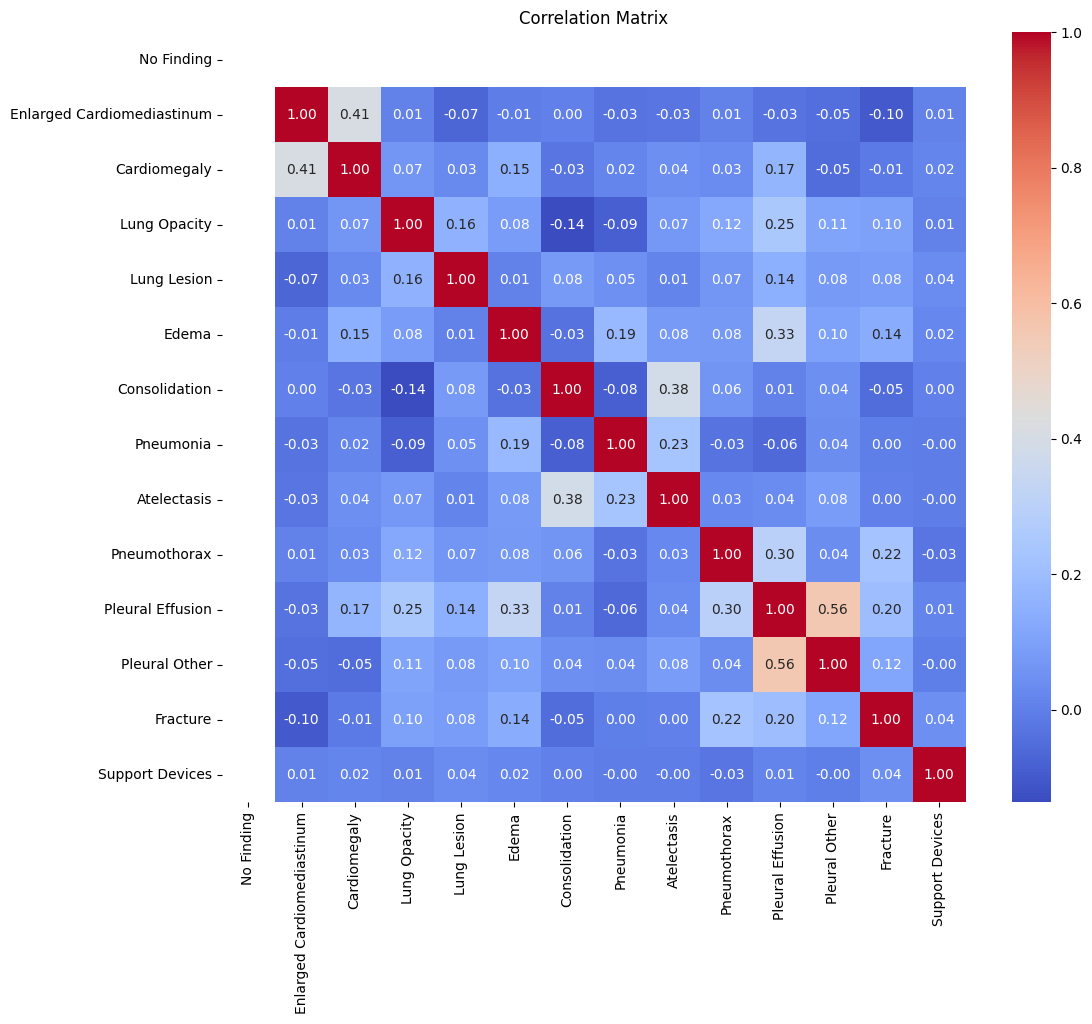

In [10]:
import seaborn as sns

# Hitung korelasi antar kolom pada dataset train_df (hanya kolom numerik)
numeric_columns = train_df.select_dtypes(include=['number'])
correlation_table = numeric_columns.corr()

# Tampilkan tabel korelasi
print("Tabel Korelasi:")
import matplotlib.pyplot as plt

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_table, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

## MENYIAPKAN DATASET

### Membuat Data Train dari Data Valid

In [11]:
# Bagi valid_df menjadi validasi dan test set
valid_df, test_df = train_test_split(valid_df, test_size=0.2, random_state=42)
print("valid_df menjadi validasi dan test set")

valid_df menjadi validasi dan test set


In [12]:
print(f"Jumlah data train: {len(train_df)}")
print(f"Jumlah data validasi: {len(valid_df)}")
print(f"Jumlah data test: {len(test_df)}\n")

Jumlah data train: 223414
Jumlah data validasi: 187
Jumlah data test: 47



=== Informasi Data Sampel ===

Label Penyakit:
Path: CheXpert-v1.0-small/train/patient24498/study1/view2_lateral.jpg
No Finding: nan
Enlarged Cardiomediastinum: nan
Cardiomegaly: nan
Lung Opacity: -1.0
Lung Lesion: nan
Edema: nan
Consolidation: nan
Pneumonia: nan
Atelectasis: -1.0
Pneumothorax: nan
Pleural Effusion: 1.0
Pleural Other: nan
Fracture: nan
Support Devices: nan


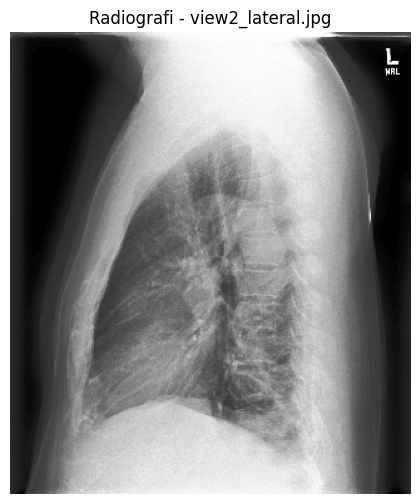

In [13]:
# Pilih 1 sampel acak
random_sample = train_df.sample(1).iloc[0]

# Tampilkan informasi data
print("=== Informasi Data Sampel ===")
# print(f"Path: {random_sample['Path']}")
# print(f"Jenis Kelamin: {random_sample['Sex']}")
# print(f"Usia: {random_sample['Age']}")
# print(f"View: {random_sample['Frontal/Lateral']}")
print("\nLabel Penyakit:")
for col in train_df.columns[0:]:  # Kolom penyakit dimulai dari indeks 5
    print(f"{col}: {random_sample[col]}")

# Load dan tampilkan gambar
try:
    img_path = 'datasets/' + random_sample['Path']
    img = Image.open(img_path).convert('RGB')
    
    plt.figure(figsize=(8, 6))
    plt.imshow(img, cmap='gray')
    plt.title(f"Radiografi - {os.path.basename(img_path)}")
    plt.axis('off')
    plt.show()
    
except FileNotFoundError:
    print(f"\nERROR: File tidak ditemukan di path: {img_path}")
    print("Pastikan:")
    print("1. Dataset gambar sudah di-download")
    print("2. Path relatif/absolut benar")
    print("3. Struktur folder sesuai dengan kolom 'Path'")
except Exception as e:
    print(f"\nERROR: {str(e)}")